### Notebook C

# In Banks We Trust:

## Predicting the Propensity to Avail Formal Financial Services in the Philippines
### Sensitivity Analysis - Importance of Predictors: Demographics vs. Financial Attitude

In this notebook, the model accuracy and importance of demographics and financial attitude as predictors of propensity to save in formal financial channels are determined and compared. This notebook is divided into two parts. Part 1 presents the results of the classifier machine learning models using age and education as the predictors. While part 2 discusses how financial attitudes as behavior explain the target variable. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### Data Preprocessing

In [2]:
raw = pd.read_csv('CFS extracted data.csv')
raw.shape
#Pre-processing
raw['Region'] = raw['Region'].astype('category')

# Convert unknown education to median
e = []
for ed in raw.Education:
    if ed==11:    
        e.append(np.median(raw.Education))
    else:
        e.append(ed)
raw['Education']=e
# Filter only those without Account
df = raw.groupby('Deposit_Account').get_group(0)

# Filter only those who have no account because they have no extra money
df = df[df.Reason_no_acct=='Do not have enough money']

# Filter only those who will save/invest in Formal or informal channels if they have extra money
df = df[df.Extra_Money!='Spend']
df = df[df.Extra_Money!='Both']
df = df.drop(['Deposit_Account', 'Reason_no_acct', 'Extra_Money_Informal', 'Extra_Money_Formal', 'Extra_Money_Spend', ], axis=1)

## Part 1: Age and Education

In [12]:
X2 = df[['Age', 'Education']]

In [13]:
# Check if data is balanced
np.unique(y, return_counts=True)

(array(['Formal', 'Informal'], dtype=object), array([4423, 4357], dtype=int64))

In [14]:
def get_pcc(y):
    nums = np.unique(y, return_counts=True)[1]
    return sum((nums/nums.sum())**2)

print("Proportion Chance Criterion = {:.1f}%".format(get_pcc(df[target])*100))
print("Threshold Accuracy = {:.1f}%".format(1.25*get_pcc(df[target])*100))

Proportion Chance Criterion = 50.0%
Threshold Accuracy = 62.5%


In [15]:
models2 = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

depth_list = [10, 15, 20, 30, 50]
estimator_list = [100, 500, 1000]
rate_list = [1, 0.5, 0.2, 0.1, 0.05]

cl2_params = {
    models2[0] : {'max_depth' : depth_list},
    models2[1] : {'max_depth' : depth_list, 'n_estimators' : estimator_list},
    models2[2] : {'max_depth' : depth_list, 'learning_rate' : rate_list}
}

cl2 = {
    models2[0] : DecisionTreeClassifier(max_features='sqrt', random_state=0),
    models2[1] : RandomForestClassifier(max_features='sqrt',
                                        n_jobs=-1, random_state=0),
    models2[2] : GradientBoostingClassifier(max_features='sqrt', random_state=0)
}

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, 
                                                    random_state=0)
estimator2 = {}
for est in tqdm(models2):
    gs_cv = GridSearchCV(cl2[est], param_grid=cl2_params[est], n_jobs=-1)
    gs_cv.fit(X_train, y_train)
    estimator2[est] = gs_cv
data = []
for est in models2:
    data.append({
        'ML Method' : est,
        'Test Accuracy' : estimator2[est].best_estimator_.score(X_test,
                                                                    y_test),
        'Best Parameters' : estimator2[est].best_params_
    })
full_b2 = pd.DataFrame(data, columns=['ML Method', 'Test Accuracy', 'Best Parameters'])
full_b2

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


,ML Method,Test Accuracy,Best Parameters
0,Decision Tree,0.552164,{'max_depth': 10}
1,Random Forest,0.550342,"{'max_depth': 10, 'n_estimators': 1000}"
2,Gradient Boosting,0.551253,"{'learning_rate': 0.05, 'max_depth': 15}"


In [17]:
models1_1 = ['kNN', 'Logistic Regression (L2)', 'Linear SVM (L2)',
           'Nonlinear SVM (RBF)']

kneighbors = range(1, 16)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

cl1_params = {
    models1_1[0] : {'n_neighbors':kneighbors},
    models1_1[1] : {'C':C_list},
    models1_1[2] : {'C':C_list},
    models1_1[3] : {'C':C_list, 'gamma':gamma_list}
}

cl1 = {
    models1_1[0] : KNeighborsClassifier(n_jobs=-1),
    models1_1[1] : LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1, 
                                    random_state=0),
    models1_1[2] : LinearSVC(penalty='l2', max_iter=1000, random_state=0),
    models1_1[3] : SVC(kernel='rbf', random_state=0)
}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, 
                                                    random_state=0)
scaler = MinMaxScaler().fit(X_train)
estimator1_standard = {}
for est in tqdm(models1):
    gs_cv = RandomizedSearchCV(cl1[est], param_distributions=cl1_params[est], n_jobs=-1)
    gs_cv.fit(scaler.transform(X_train), y_train)
    estimator1_standard[est] = gs_cv
data = []
for est in models1:
    data.append({
        'ML Method' : est,
        'Test Accuracy' : estimator1_standard[est].best_estimator_.score(
            scaler.transform(X_test), y_test),
        'Best Parameters' : estimator1_standard[est].best_params_
    })
full_a2 = pd.DataFrame(data, columns=['ML Method', 'Test Accuracy', 'Best Parameters'])
full_a2

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Use

,ML Method,Test Accuracy,Best Parameters
0,kNN,0.527107,{'n_neighbors': 13}
1,Logistic Regression (L2),0.567654,{'C': 0.021544346900318846}
2,Linear SVM (L2),0.564920,{'C': 0.0016681005372000592}
3,Nonlinear SVM (RBF),0.560820,"{'gamma': 46.41588833612782, 'C': 0.2782559402..."


In [19]:
full_2 = pd.concat([full_a2, full_b2]).reset_index(drop=True)
full_2

,ML Method,Test Accuracy,Best Parameters
0,kNN,0.527107,{'n_neighbors': 13}
1,Logistic Regression (L2),0.567654,{'C': 0.021544346900318846}
2,Linear SVM (L2),0.564920,{'C': 0.0016681005372000592}
3,Nonlinear SVM (RBF),0.560820,"{'gamma': 46.41588833612782, 'C': 0.2782559402..."
4,Decision Tree,0.552164,{'max_depth': 10}
5,Random Forest,0.550342,"{'max_depth': 10, 'n_estimators': 1000}"
6,Gradient Boosting,0.551253,"{'learning_rate': 0.05, 'max_depth': 15}"


## Part 2: Financial Attitudes

#### Setting Inputs for our ML Model

In [3]:
target = 'Extra_Money'
X = df[['Saving_Habit',
       'Wealth_Unconcious', 'Wealth_Allocation', 'No_Surplus',
       'Insufficient_Savings', 'Peer_Pressure', 'Growth_Desire', 'Growth_Able',
       'Budget_Difficulty', 'Risk_Tolerant', 'Delayed_Gratification',
       'Inheritance']]
y = df[target]

In [4]:
def get_pcc(y):
    nums = np.unique(y, return_counts=True)[1]
    return sum((nums/nums.sum())**2)

print("Proportion Chance Criterion = {:.1f}%".format(get_pcc(df[target])*100))
print("Threshold Accuracy = {:.1f}%".format(1.25*get_pcc(df[target])*100))

Proportion Chance Criterion = 50.0%
Threshold Accuracy = 62.5%


#### ML Model

In [5]:
# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Others
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.exceptions import ConvergenceWarning
from tqdm.autonotebook import tqdm

C:\Users\Ross\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


#### Tree Based Classifiers

In [6]:
models2 = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

depth_list = [10, 15, 20, 30, 50]
estimator_list = [100, 500, 1000]
rate_list = [1, 0.5, 0.2, 0.1, 0.05]

cl2_params = {
    models2[0] : {'max_depth' : depth_list},
    models2[1] : {'max_depth' : depth_list, 'n_estimators' : estimator_list},
    models2[2] : {'max_depth' : depth_list, 'learning_rate' : rate_list}
}

cl2 = {
    models2[0] : DecisionTreeClassifier(max_features='sqrt', random_state=0),
    models2[1] : RandomForestClassifier(max_features='sqrt',
                                        n_jobs=-1, random_state=0),
    models2[2] : GradientBoostingClassifier(max_features='sqrt', random_state=0)
}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=0)
estimator2 = {}
for est in tqdm(models2):
    gs_cv = GridSearchCV(cl2[est], param_grid=cl2_params[est], n_jobs=-1)
    gs_cv.fit(X_train, y_train)
    estimator2[est] = gs_cv
data = []
for est in models2:
    data.append({
        'ML Method' : est,
        'Test Accuracy' : estimator2[est].best_estimator_.score(X_test,
                                                                    y_test),
        'Best Parameters' : estimator2[est].best_params_
    })
full_b = pd.DataFrame(data, columns=['ML Method', 'Test Accuracy', 'Best Parameters'])
full_b

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


,ML Method,Test Accuracy,Best Parameters
0,Decision Tree,0.577221,{'max_depth': 30}
1,Random Forest,0.615490,"{'max_depth': 15, 'n_estimators': 100}"
2,Gradient Boosting,0.590433,"{'learning_rate': 0.1, 'max_depth': 15}"


####  Non - Tree Based Classifiers (KNN, Logistic Regression (L2) , Support Vector Machines(L2 and RBF) )

In [8]:
models1 = ['kNN', 'Logistic Regression (L2)', 'Linear SVM (L2)',
           'Nonlinear SVM (RBF)']

kneighbors = range(1, 16)
C_list = np.logspace(-5, 5, num=10)
gamma_list = np.logspace(-5, 5, num=10)

cl1_params = {
    models1[0] : {'n_neighbors':kneighbors},
    models1[1] : {'C':C_list},
    models1[2] : {'C':C_list},
    models1[3] : {'C':C_list, 'gamma':gamma_list}
}

cl1 = {
    models1[0] : KNeighborsClassifier(n_jobs=-1),
    models1[1] : LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1, 
                                    random_state=0),
    models1[2] : LinearSVC(penalty='l2', max_iter=1000, random_state=0),
    models1[3] : SVC(kernel='rbf', random_state=0)
}

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=0)
scaler = MinMaxScaler().fit(X_train)
estimator1_standard = {}
for est in tqdm(models1):
    gs_cv = RandomizedSearchCV(cl1[est], param_distributions=cl1_params[est], n_jobs=-1)
    gs_cv.fit(scaler.transform(X_train), y_train)
    estimator1_standard[est] = gs_cv
data = []
for est in models1:
    data.append({
        'ML Method' : est,
        'Test Accuracy' : estimator1_standard[est].best_estimator_.score(
            scaler.transform(X_test), y_test),
        'Best Parameters' : estimator1_standard[est].best_params_
    })
full_a = pd.DataFrame(data, columns=['ML Method', 'Test Accuracy', 'Best Parameters'])
full_a

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Use

,ML Method,Test Accuracy,Best Parameters
0,kNN,0.596355,{'n_neighbors': 13}
1,Logistic Regression (L2),0.568565,{'C': 0.2782559402207126}
2,Linear SVM (L2),0.569932,{'C': 0.021544346900318846}
3,Nonlinear SVM (RBF),0.613212,"{'gamma': 0.2782559402207126, 'C': 46.41588833..."


#### Summarizing the results of the classifiers

In [10]:
full = pd.concat([full_a, full_b]).reset_index(drop=True)
full

,ML Method,Test Accuracy,Best Parameters
0,kNN,0.596355,{'n_neighbors': 13}
1,Logistic Regression (L2),0.568565,{'C': 0.2782559402207126}
2,Linear SVM (L2),0.569932,{'C': 0.021544346900318846}
3,Nonlinear SVM (RBF),0.613212,"{'gamma': 0.2782559402207126, 'C': 46.41588833..."
4,Decision Tree,0.577221,{'max_depth': 30}
5,Random Forest,0.615490,"{'max_depth': 15, 'n_estimators': 100}"
6,Gradient Boosting,0.590433,"{'learning_rate': 0.1, 'max_depth': 15}"


Selecting Random Forest as our Classifier owing to its highest accuracy. The attained accuracy is slightly less than our threshold of 62%

#### Feature Importance

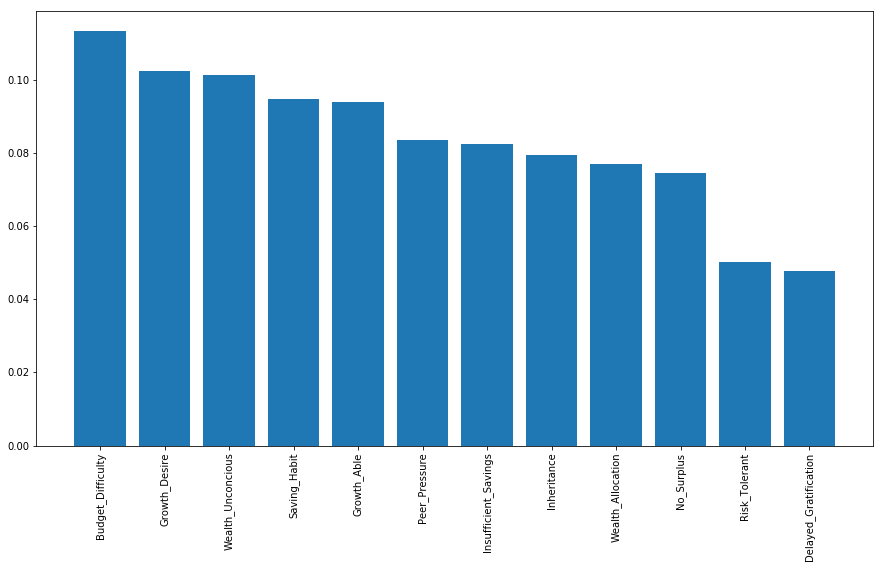

In [11]:
best = full['ML Method'][full['Test Accuracy'].idxmax()]
mdl = estimator2[best].best_estimator_
ranks = sorted(list(zip(mdl.feature_importances_, X.columns)), key=lambda x: -x[0])
plt.figure(figsize=(15,8))
plt.bar(list(zip(*ranks))[1] ,list(zip(*ranks))[0])
plt.xticks(rotation=90);

Note that the details of all the above features have been explained in the main notebook, kindly refer to it for more details

## Summary

**Age and Educational Attainment**

A 56.7% Test Accuracy was achieved using the Logistic (L2) Regression, while a 55% accuracy was achieved using the Random Forest Machine Learning Model in taking Age and Education as a subset of the validation dataset.

**Financial Attitude**

The Random Forest model results in an accuracy of 61.5% Test Accuracy for features included under Financial Attitude. Highest contributing features are Budgeting Capability, Desire to Grow personal wealth, and the preference not to think about money.